## Working with Block Group Data within a CBSA

In the U.S. Census Geography hierarchy, block groups are
within census tracts, which are within counties, which 
are within states. This hierarchy is called on-spine.
But sometimes we want to look at all the block groups within
an off-spine geography like a Core Based Statistical Area (CBSA).
CBSAs represent metropolitan and micropolitan areas and sometimes cross state
boundaries. This notebook demonstrates how to manage this
kind of data using `censusdis` to load data and geographies and 
some additional [GeoPandas](https://geopandas.org) spatial operations.

In [1]:
# So we can run from within the censusdis project and find the packages we need.
import os
import sys

sys.path.append(
    os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir)))
)

## Imports and Configuration

In [2]:
import censusdis.data as ced
import censusdis.maps as cem
import censusdis.states as states

import numpy as np
import pandas as pd
import geopandas as gpd

In [3]:
YEAR = 2020
DATASET = "acs/acs5"

In [4]:
# Median houshold income in last 12 months.
# See https://api.census.gov/data/2021/acs/acs5/groups/B19013.html
VARIABLE_MEDIAN_INCOME = "B19013_001E"

In [5]:
# The CBSAs we care about.

CBSAS = "*"
CBSAS = ["35620"]

## Map-only data

We will download some map data that we will then combine with
actual census data later.

### State boundaries for plotting

In [6]:
gdf_state = ced.download(
    DATASET,
    YEAR,
    ["NAME"],
    state=states.ALL_STATES_DC_AND_PR,
    with_geometry=True,
)

### Core Based Statistical Areas (CBSAs)

These are also known in the API as "Metropolitan statistical area/micropolitan statistical area."

In [7]:
gdf_cbsa = ced.download(
    DATASET,
    YEAR,
    ["NAME"],
    metropolitan_statistical_area_micropolitan_statistical_area=CBSAS,
    with_geometry=True,
)

### Join states and CBSAs

This lets us figure out which states we need data from.

In [8]:
gdf_state_cbsa = gdf_cbsa.sjoin(gdf_state, lsuffix="STATE", rsuffix="CBSA")

In [9]:
states_covered = list(gdf_state_cbsa["STATE"].unique())

[states.NAMES_FROM_IDS[state] for state in states_covered]

['New Jersey', 'Pennsylvania', 'Connecticut', 'New York']

## Get the median income data at the block group level

We only query it for the states we need to cover the CBSA. That
way we limit the amount of data we download only to throw it away
in the next step. We'll still load all block grooups for the entirity
of each state, but at least we will leave out the states that don't
intersect the CBSA at all.

In [10]:
gdf_bg_data = gpd.GeoDataFrame(
    pd.concat(
        ced.download(
            DATASET,
            YEAR,
            [VARIABLE_MEDIAN_INCOME],
            with_geometry=True,
            set_to_nan=True,
            state=state,
            block_group="*",
        ).dropna()
        for state in states_covered
    )
)

### Spatial join to strip down from whole states to the CBSA only

In [11]:
gdf_cbsa_bg_data = cem.sjoin_mostly_contains(
    gdf_cbsa, gdf_bg_data, large_suffix="CBSA", small_suffix="DATA"
)

## Plot

Before we plot, let's generate the portion of the states that lies
within the CBSA so we can easily plot state boundaries.

In [12]:
gdf_states_in_cbsas = gdf_cbsa.overlay(
    gdf_state[gdf_state["STATE"].isin(states_covered)],
    how="intersection",
    keep_geom_type=True,
)

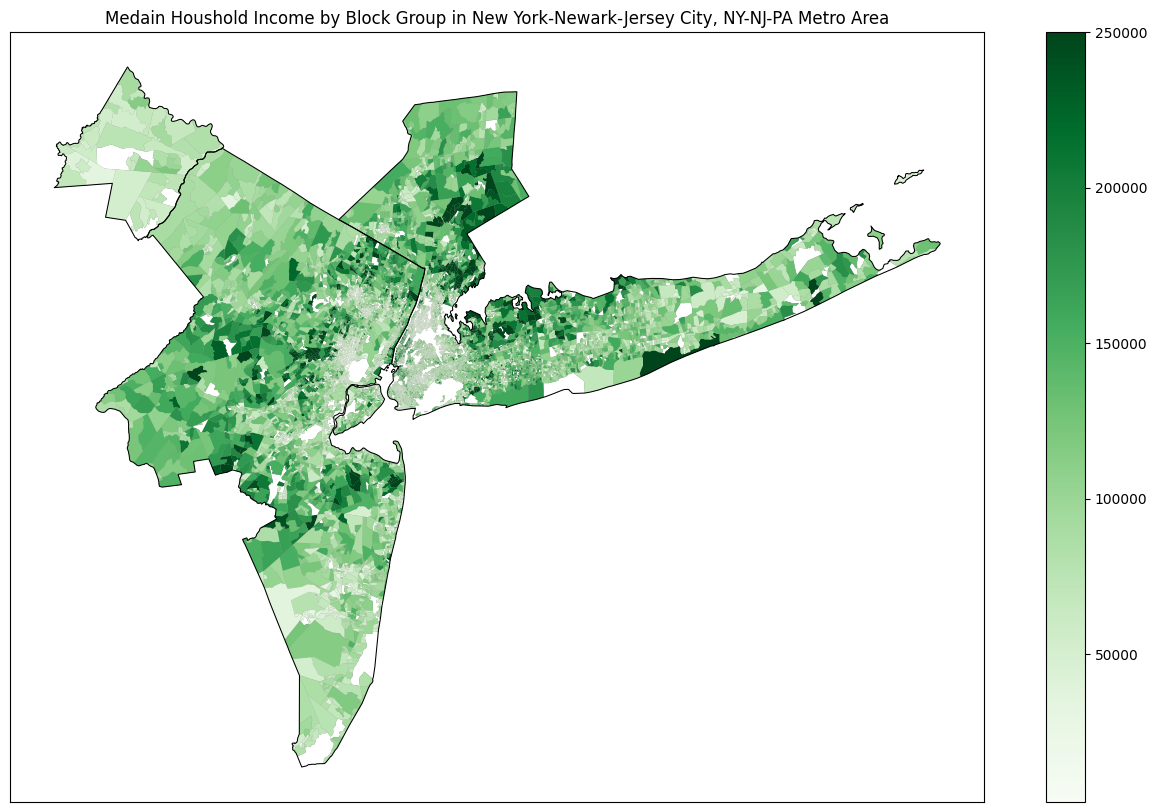

In [13]:
ax = gdf_cbsa_bg_data.plot(color="grey", figsize=(16, 10), legend=True)
ax = gdf_cbsa_bg_data.plot(VARIABLE_MEDIAN_INCOME, cmap="Greens", ax=ax, legend=True)
gdf_states_in_cbsas.boundary.plot(ax=ax, color="black", linewidth=0.75)

cbsa_name = ",".join(gdf_cbsa["NAME"])

ax.set_title(f"Medain Houshold Income by Block Group in {cbsa_name}")

ax.tick_params(
    left=False,
    right=False,
    bottom=False,
    labelleft=False,
    labelbottom=False,
)